In [383]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

In [384]:
# Pull necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
rGDP = dl.pull("GDP/Real")
sr = dl.pull("ShortRates")

# 0. Overview

In this notebook, we try and get some intuition for why GDP might be a driver of bond returns. We also try to construct and indicator which captures changes in GDP relative to a recent average. 

`TODO`
- Generate an indicator which isn't quarterly!

# 1. Relationship between GDP and Short Rates

What would we expect here? As GDP growth continues, central banks tighten the economy, forcing rates up. So we might expect changes in short rates to follow changes in GDP, perhaps with some lag. 

The aforementioned relationship does appear. Short rates follow (roughly) the ups and downs of GDP, with a little lag. 

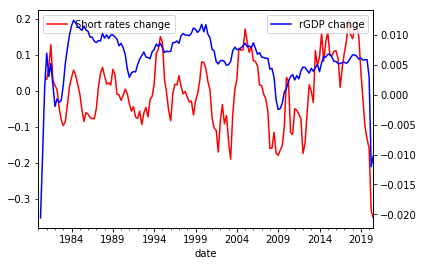

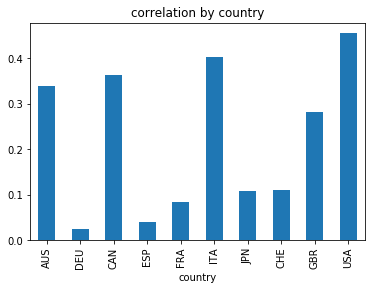

In [385]:
# Get change in short rates (indexed by month - change to quarters), and take a rolling average.
sr_chg = sr.resample('Q').mean().pct_change()
sr_chg_sma = sr_chg.rolling(4).mean() # 1 year rolling average. 

# Get change in rGDP, and take a rolling average. 
rGDP_chg = rGDP.pct_change()
rGDP_chg_ewm = rGDP_chg.ewm(span=12).mean()

# Plot change in short rates and change in GDP. 
fig, ax = plt.subplots()
sr_chg_sma['USA'].plot(color='red', label='Short rates change')
plt.legend()
rGDP_chg_ewm['USA'].plot(ax=ax.twinx(), color='blue', label='rGDP change')
plt.legend()
plt.show()

sr_chg_sma.corrwith(rGDP_chg_ewm).plot.bar(title='correlation by country')

Let's try manipulate the lag and see if we can get better correlation. Let's do this by moving GDP forward a few quarters. 3 quarters works pretty well. 

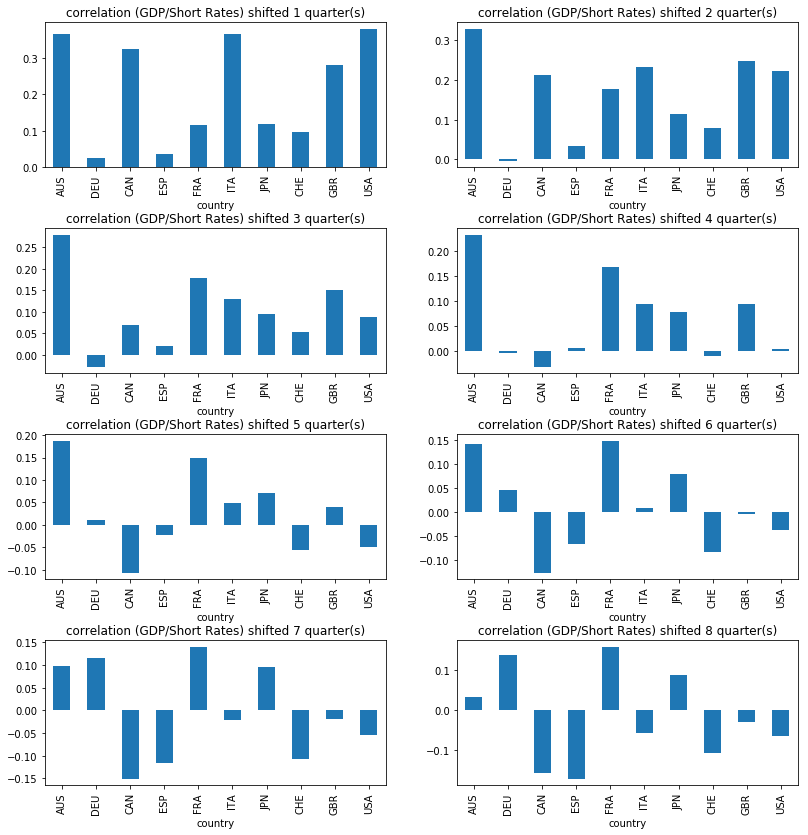

In [386]:
rGDP_chg_ewm_shifted = rGDP_chg_ewm

# Plot the correlation. 
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, shift in enumerate(range(1, 9)): 
    ax = axs[i//2][i%2]
    rGDP_chg_ewm_shifted = rGDP_chg_ewm.shift(shift)
    sr_chg_sma.corrwith(rGDP_chg_ewm_shifted).plot.bar(ax=ax, title='correlation (GDP/Short Rates) shifted {} quarter(s)'.format(shift))

# 2. Relationship between GDP and Bond Returns

What would we expect here? As above, changes in short rates follow changes in GDP. Changes in rates are inversely related to bond returns, so we might expect change in GDP and change in bond returns to be opposites (i.e. reflections of one another). 

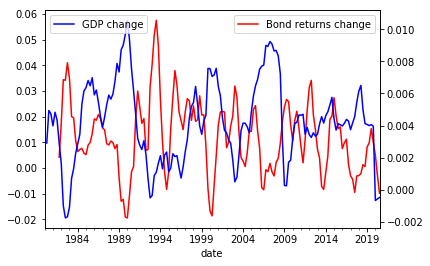

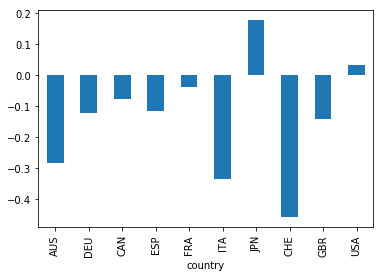

In [410]:
# Get the change q-on-q of bond returns. 
bri_chg = bri.resample('Q').mean().pct_change()
bri_chg_sma = bri_chg.rolling(4).mean() # 1-year rolling average. 

# Plot change in bond returns and change in GDP. 
fig, ax = plt.subplots()
bri_chg_sma['CHE'].plot(color='red', label='Bond returns change')
plt.legend()
rGDP_chg_ewm['CHE'].plot(ax=ax.twinx(), color='blue', label='GDP change')
plt.legend(loc=2)
plt.show()

bri_chg_sma.corrwith(rGDP_chg_sma).plot.bar()

This inverse relationship is somewhat apparent. The spike in GDP change in 2005 corresponds to a big dip in bond prices in 2006. Various other instances are visible, although with some exceptions. Let's see if introducing a lag has the same effect (improving correlation). Again, 3 months works relatively well (in terms of uniformity - most countries have negative correlation). 

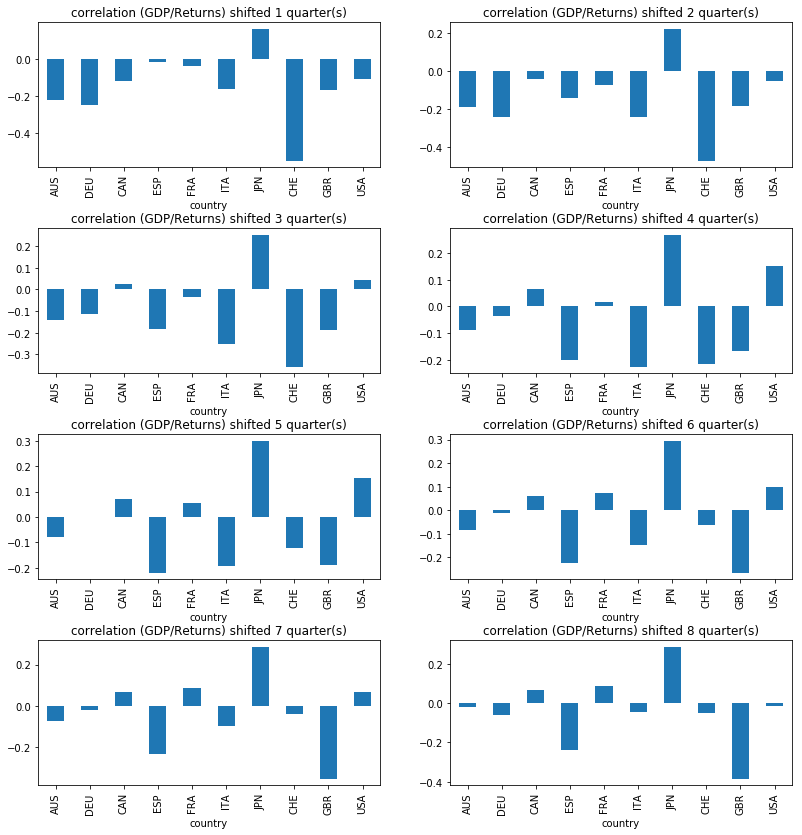

In [388]:
rGDP_chg_ewm_shifted = rGDP_chg_ewm

# Plot the correlation. 
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, shift in enumerate(range(1, 9)): 
    ax = axs[i//2][i%2]
    rGDP_chg_ewm_shifted = rGDP_chg_ewm.shift(shift)
    bri_chg_sma.corrwith(rGDP_chg_ewm_shifted).plot.bar(ax=ax, title='correlation (GDP/Returns) shifted {} quarter(s)'.format(shift))

# 2. Build the indicator

In [404]:
# Get the percentage change period-to-period. 
rGDP_chg = rGDP.pct_change()

# For each country (column), get a rolling average for the past 3 years. 
sma = rGDP_chg.rolling(12).mean()
std = sma.std()

# Turn the change into a zscore. 
zscore = (rGDP_chg - sma) / std
zscore = zscore.shift(3) # Shift it forward 3 qs. 

# Smooth out the zscore by taking a rolling average for the past 4 qs.
zscore = zscore.ewm(4).mean()

Let's explore the relationship between this zscore and bond returns. 

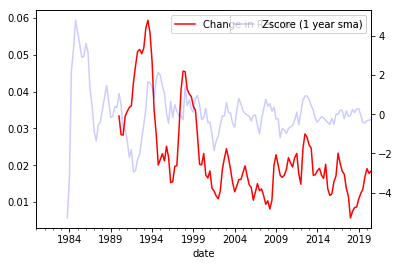

In [405]:
# Get bond returns. Resample to quarterly. 
bri_q = bri.resample('Q').mean()

# Get percentage change period-to-period. 
bri_q_chg = bri_q.pct_change()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bri_q_chg['AUS'].rolling(12).mean().plot(ax=ax1, color='red', label='Change in Returns (3 year sma)')
zscore['AUS'].plot(ax=ax2, color='blue', alpha=0.2, label="Zscore (1 year sma)")
ax1.legend()
ax2.legend()

# Plot a restricted date window.
# bri_q_chg.loc['2000-01-01':'2005-01-01']['USA'].plot(ax=ax1, color='red')
# zscore.loc['2000-01-01':'2005-01-01']['USA'].plot(ax=ax2, color='blue')

Let's look at the correlation between z score and change in returns. 

In [406]:
correlation = bri_q_chg.corrwith(zscore, method='pearson', axis=0)
correlation

country
AUS   -0.155842
DEU    0.028806
CAN    0.033272
ESP   -0.054869
FRA   -0.040202
ITA   -0.225011
JPN    0.014677
CHE   -0.105984
GBR   -0.021333
USA    0.133829
dtype: float64

Let's look at the relationship between our indicator and interest rates. 

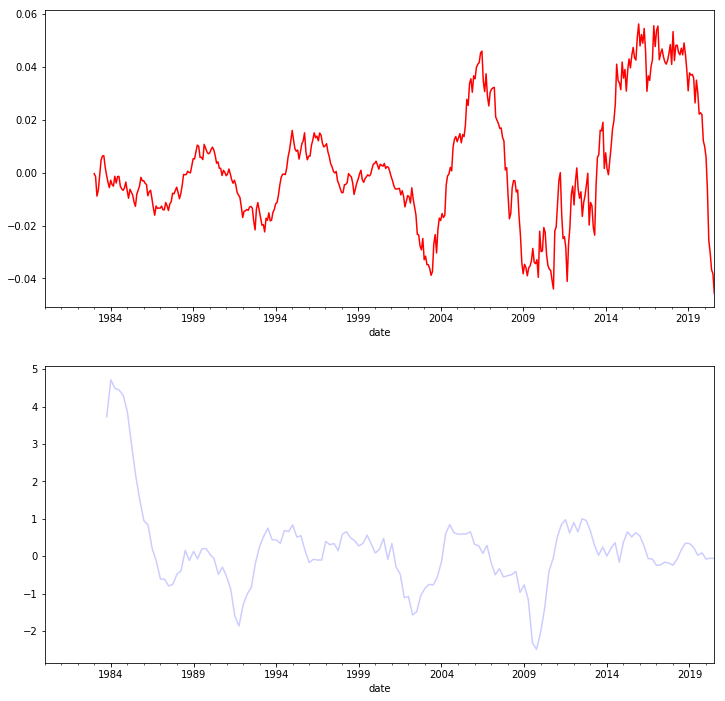

In [407]:
# Get change in short rates. 
sr_chg = sr.pct_change()
sr_chg_sma = sr_chg.rolling(36).mean()

# Plot change in short rates and our zscore. 
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

sr_chg_sma['USA'].plot(ax=axs[0], color='red', label='Short rates change')
zscore['USA'].plot(ax=axs[1], \
        color='blue', alpha=0.2, label="Zscore (3 year sma)")

# 3. Return stream

As it stands, this indicator is pretty abysmal at generating returns. Need to refine how the indicator is constructed. 

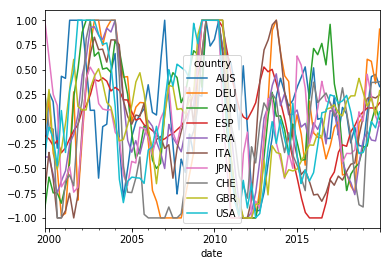

In [408]:
# Convert the z-score to a signal by inverting it, then capping. 
signal = (-1 * zscore).clip(upper=1, lower=-1)
signal = signal.resample('B').interpolate(method='linear')
signal = signal.dropna()
signal = signal[signal.index < '2020-01-01']
signal.plot()

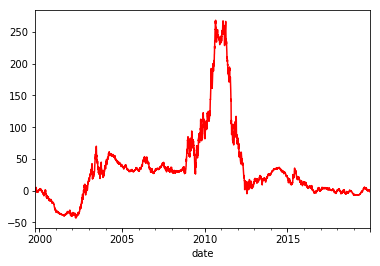

In [409]:
# Calculate cumulative returns. 
returns = BondRetIdx.pct_change().loc[signal.index].shift(-1)
returns = (signal * returns).dropna().sum(axis=1)        
cumul_returns = ((returns + 1).cumprod() - 1) * 100

# Plot. 
cumul_returns.plot(title="", color='red')